The dataset is originally from the Centers for Disease Control and Prevention: link [here](https://nccd.cdc.gov/500_Cities/rdPage.aspx?rdReport=DPH_500_Cities.ComparisonReport)

The dataset was compiled on Kaggle: link [here](https://www.kaggle.com/cdc/500-cities)

The variables in this dataset can be divided into four groups:

### Location/Identificaion
**StateAbbr** - state abbreviation<br>
**PlaceName** - city name<br>
**PlaceFIPS** - Federal Information Processing System code. Identifies county <br>
**Population2010** - population from 2010 US Census<br>
**Geolocation** - latitude and longitude of location<br><br>

### Health Outcomes
**ARTHRITIS** - arthritis among adults aged 18 years and older<br>
**BPHIGH** - high blood pressure among adults aged 18 years and older<br>
**CANCER** - cancer (excluding skin cancer) among adulsts aged 18 years and older<br>
**CASTHMA** - current asthma among adults aged 18 years and older<br>
**CHD** - coronary heart disease among adults aged 18 years and older<br>
**COPD** - chronic obstructive pulmonary disease among adults aged 18 years and older<br>
**DENTAL** - visits to dentist or dental clinic among adults aged 18 years and older<br>
**DIABETES** - diagnosed diabetes among adults aged 18 years and older<br>
**HIGHCHOL** - high cholesterol among adults aged 18 years and older<br>
**KIDNEY** - chronic kidney disease among adults aged 18 years and older<br>
**MHLTH** - mental health not good for at least 14 days among adults aged 18 years and older<br>
**PHLTH** - physical health not good for at least 14 days among adults aged 18 years and older<br>
**STROKE** - stroke among adults aged 18 years and older<br>
**TEETHLOST** - all teeth lost among adults aged 65 years and older<br><br>

### Prevention
**ACCESS2** - current lack of health insurance among adults aged 18-64 years <br>
**BPMED** - taking medicine for high blood pressure control among adults aged 18 years and older with high blood pressure<br>
**CHECKUP** - visits to doctor for routine checkup within the past year among adults aged 18 years and older <br>
**CHOLSCREEN** - cholesterol screening among adults aged 18 years and older<br>
**COLON_SCREEN** - fecal occult blood test, sigmoidoscopy, or solonoscopy among adults aged 50-75 years <br>
**COREM** - older adult males aged 65 and older who are up to date on a core set of clinincal preventive services<br>
**COREW** - older adult females aged 65 and older who are up to date on a core set of clinincal preventive services<br>
**DENTAL** - visits to dentist or dental clinic among adults aged 18 years and older<br>
**MAMMOUSE** - mammography use among women aged 50-74 years<br>
**PAPTEST** - Papanicolaou smear use among adult women aged 21-65 years<br><br>

### Unhealthy Behaviors
**BINGE** - binge drinking among adults aged 18 years and older <br>
**CSMOKING** - current smoking among adults 18 and older<br>
**LPA** - no leisure-time physical activity aong adults aged 18 and older<br>
**OBESITY** - obesity among adults aged 18 and older<br>
**SLEEP** - sleeping less than 7 hours among adults aged 18 and older<br><br>

The crude prevalence and the age-adjusted prevalence for each of the features in the last three groups are measured in this dataset. The ranges in the 95% confidence interval are also in the dataset.<br>

For example, `ARTHRITIS_CrudePrev` represents the crude prevalence of arthritis and `ARTHRITIS_Adj95CI` represents the confidence interval of the age-adjusted prevalence of arthritis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [2]:
cdc = pd.read_csv('500_Cities_CDC.csv')
cdc_og = cdc.copy()

In [3]:
cdc_og.head(2)

,StateAbbr,PlaceName,PlaceFIPS,Population2010,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ACCESS2_AdjPrev,ACCESS2_Adj95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,SLEEP_Adj95CI,STROKE_CrudePrev,STROKE_Crude95CI,STROKE_AdjPrev,STROKE_Adj95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,TEETHLOST_AdjPrev,TEETHLOST_Adj95CI,Geolocation
0,AL,Birmingham,107000,212237,22.6,"(22.1, 23.0)",21.4,"(21.0, 21.8)",32.6,"(32.5, 32.8)",...,"(46.6, 47.0)",5.0,"( 5.0, 5.1)",5.0,"( 5.0, 5.1)",26.1,"(25.1, 27.2)",25.9,"(25.0, 26.9)","(33.52756637730, -86.7988174678)"
1,AL,Hoover,135896,81619,10.6,"(10.2, 11.1)",10.2,"( 9.7, 10.7)",26.3,"(26.0, 26.6)",...,"(34.2, 35.0)",2.3,"( 2.2, 2.3)",2.2,"( 2.1, 2.3)",9.6,"( 8.6, 10.8)",9.5,"( 8.5, 10.9)","(33.37676027290, -86.8051937568)"


I replace the geolocation column with two separate columns for latitude and longitude:

In [4]:
lat_lon = cdc['Geolocation'].str.split(', ', expand= True)
lat_lon[0] = lat_lon[0].str.replace('(', '')
lat_lon[1] = lat_lon[1].str.replace(')', '')
lat_lon = lat_lon.astype('double')

In [5]:
cdc['Lat'] = lat_lon[0]
cdc['Lon'] = lat_lon[1]

cdc_og['Lat'] = lat_lon[0]
cdc_og['Lon'] = lat_lon[1]

cdc = cdc.drop(columns=['Geolocation', 'StateAbbr', 'PlaceName', 'PlaceFIPS', 'Population2010'])

I will also create separate columns for the lower and upper bounds of the confidence intervals for each variable

In [6]:
age_cols = list(cdc.filter(like='AdjPrev'))
ci_cols = list(cdc.filter(like='95CI'))

In [7]:
for col in ci_cols:
    ci = cdc[col].str.split(', ', expand= True)
    ci[0] = ci[0].str.replace('(', '')
    ci[1] = ci[1].str.replace(')', '')
    
    cdc[f'{col} min'] = ci[0].astype(float)
    cdc[f'{col} max'] = ci[1].astype(float)

cdc = cdc.drop(columns = ci_cols)

Then, I split the data into different dataframes, one using the age-adjusted data, and the other using the crude data.

In [8]:
#Reorder the columns to group outcomes, prevention, and habits
cdc_age = cdc[['ARTHRITIS_AdjPrev',
 'BPHIGH_AdjPrev',
 'CANCER_AdjPrev',
 'CASTHMA_AdjPrev',
 'CHD_AdjPrev',
 'COPD_AdjPrev',
 'DIABETES_AdjPrev',
 'HIGHCHOL_AdjPrev',
 'KIDNEY_AdjPrev',
 'MHLTH_AdjPrev',
 'PHLTH_AdjPrev',
 'STROKE_AdjPrev',
 'TEETHLOST_AdjPrev',
'ACCESS2_AdjPrev',
 'BPMED_AdjPrev',
 'CHECKUP_AdjPrev',
 'CHOLSCREEN_AdjPrev',
 'COLON_SCREEN_AdjPrev',
 'COREM_AdjPrev',
 'COREW_AdjPrev',
 'DENTAL_AdjPrev',
 'MAMMOUSE_AdjPrev',
'PAPTEST_AdjPrev',
'BINGE_AdjPrev',
 'CSMOKING_AdjPrev',
 'LPA_AdjPrev',
 'OBESITY_AdjPrev',
 'SLEEP_AdjPrev']]

Scale the data:

In [10]:
scaler = StandardScaler()
cdc_scaled = scaler.fit_transform(cdc)
cdc_age_scaled = pd.DataFrame(scaler.fit_transform(cdc_age), index = cdc_age.index, columns = cdc_age.columns)
cdc_crude_scaled = pd.DataFrame(scaler.fit_transform(cdc_crude), index = cdc_crude.index, columns = cdc_crude.columns)

Find the best number of clusters to use via the elbow method:

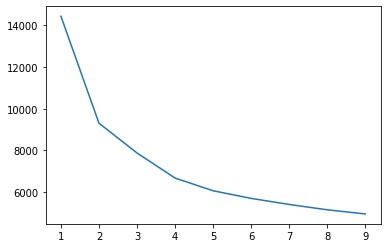

In [35]:
ks = range(1,10)
inertias = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(cdc_age_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(ks, inertias)

4 or 5 clusters seems to be a good place to start. I tried both k = 4 and k = 5, and I think k = 4 makes the most sense. Five clusters makes one group almost a subset of the other.

In [53]:
k =4 
kmeans_age = KMeans(n_clusters = k)
kmeans_age.fit(cdc_age_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

I use principal component analysis to reduce the dimensions to 2 for visualization purposes

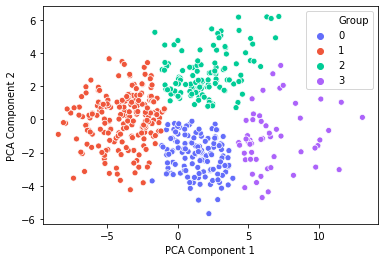

In [89]:
pca = PCA(n_components=2)
components = pca.fit_transform(cdc_age_scaled)
pca_df = pd.DataFrame(components, columns=['comp_1', 'comp_2'])
pca_df['Group'] = kmeans_age.labels_
sns.scatterplot(data = pca_df, x ='comp_1', y ='comp_2', hue = 'Group', palette =['#636dfa', '#ef563b','#00cc96','#ac63fa'])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

Add labels to the original data frame:

In [38]:
cdc_age['label'] = kmeans_age.labels_
cdc_age_scaled['label'] = kmeans_age.labels_
cdc['group'] = kmeans_age.labels_
cdc_og['group'] = kmeans_age.labels_.astype(str)

C:\Users\rhais\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



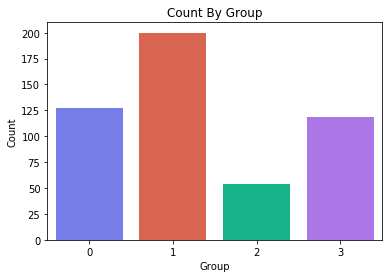

In [88]:
sns.countplot(x = 'group', data = cdc_og, palette = ['#636dfa', '#ef563b','#00cc96','#ac63fa'])
plt.xlabel('Group')
plt.ylabel('Count')
plt.title('Count By Group')
plt.show()

In [65]:
cdc_age_scaled_renamed = cdc_age_scaled.rename(columns = {'ARTHRITIS_AdjPrev': 'Arthritis', 
                                                          'BPHIGH_AdjPrev': 'HighBP',
                                                         'CANCER_AdjPrev': 'Cancer',
                                                           'CASTHMA_AdjPrev' : 'Asthma',
                                                          'CHD_AdjPrev': 'Heart Disease', 
                                                          'COPD_AdjPrev': 'COPD', 
                                                          'DIABETES_AdjPrev': 'Diabetes',
                                                           'HIGHCHOL_AdjPrev': 'High Cholesterol', 
                                                          'KIDNEY_AdjPrev': 'Kidney Disease',
                                                          'MHLTH_AdjPrev': 'Mental Health', 
                                                          'PHLTH_AdjPrev' : 'Physical Health',
                                                           'STROKE_AdjPrev': 'Stroke',
                                                          'TEETHLOST_AdjPrev': 'Teeth Lost', 
                                                          'ACCESS2_AdjPrev': 'Insurance',
                                                           'BPMED_AdjPrev': 'BP Medication',
                                                          'CHECKUP_AdjPrev': 'Checkup', 
                                                          'CHOLSCREEN_AdjPrev': 'Cholesterol Screen',
                                                           'COLON_SCREEN_AdjPrev': 'Colon Screen',
                                                          'COREM_AdjPrev': 'Core Services M',
                                                          'COREW_AdjPrev': 'Core Services F',
                                                           'DENTAL_AdjPrev': 'Dental',
                                                          'MAMMOUSE_AdjPrev': 'Mammogram', 
                                                          'PAPTEST_AdjPrev': 'Pap Test',
                                                          'BINGE_AdjPrev': 'Binge Drinking',
                                                          'CSMOKING_AdjPrev': 'Smoking', 
                                                          'LPA_AdjPrev': 'Lack of Activity',
                                                          'OBESITY_AdjPrev': 'Obesity',
                                                           'SLEEP_AdjPrev': 'Lack of Sleep'})

Text(204.0, 0.5, 'Group')

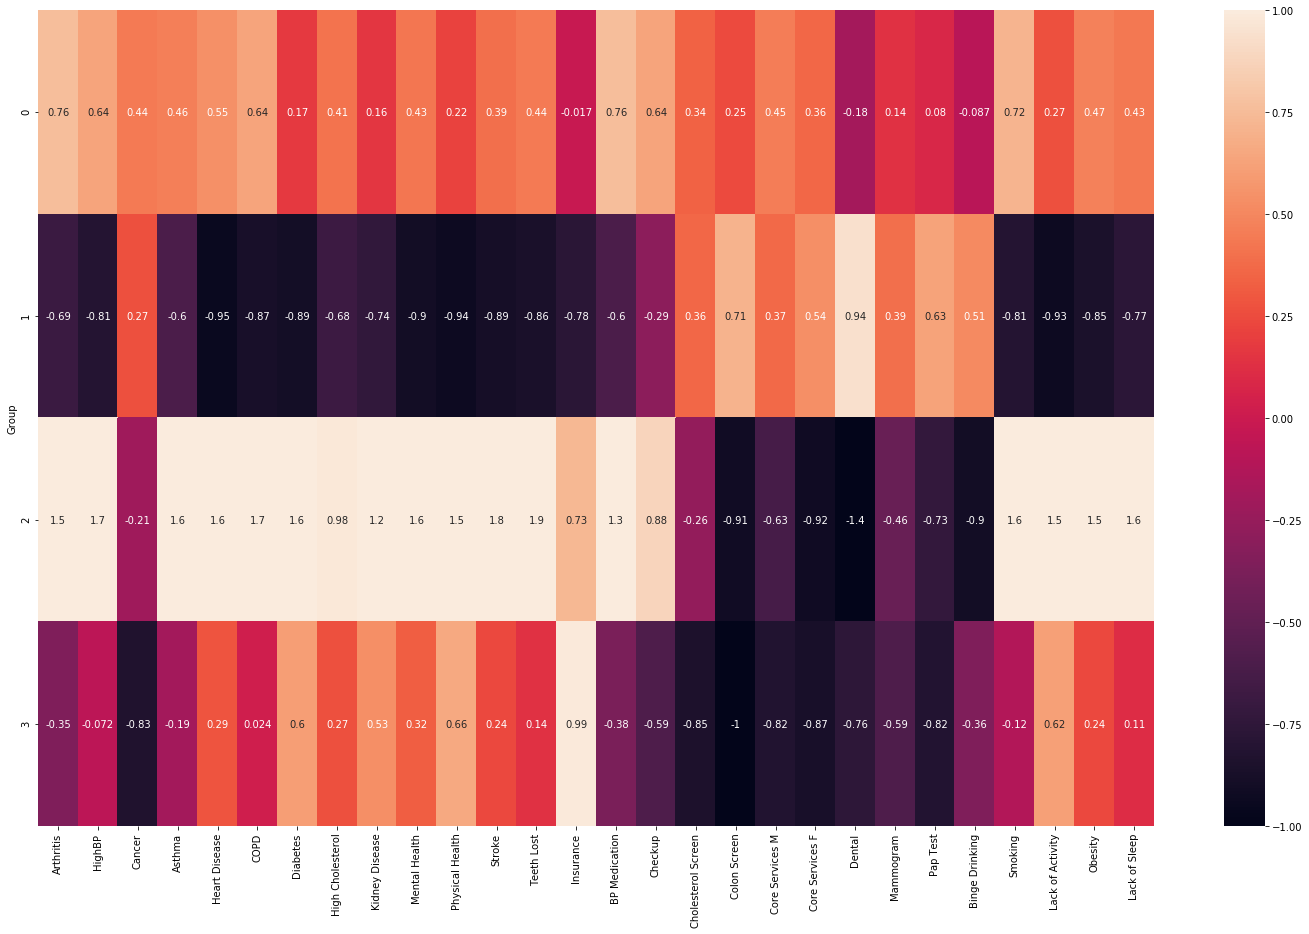

In [68]:

fig, ax = plt.subplots(1,1, figsize=(25,15)) 

sns.heatmap(cdc_age_scaled_renamed.groupby('label').mean(), ax=ax, vmin=-1, vmax=1, annot = True)
plt.ylabel('Group')


# Find confidence intervals 

In [16]:
# Split original dataframe by group
cdc_0 = cdc[cdc['group'] == 0]
cdc_1 = cdc[cdc['group'] == 1]
cdc_2 = cdc[cdc['group'] == 2]
cdc_3 = cdc[cdc['group'] == 3]

In [17]:
#split lower bound and upper bound

min_ci_cols = cdc.filter(like = 'Adj95CI min')
max_ci_cols = cdc.filter(like = 'Adj95CI max')

In [18]:
# create lists of lower bounds
mins_0 = []
mins_1 = []
mins_2 = []
mins_3 = []
for col in min_ci_cols:
    mins_0.append(cdc_0[col].min())
    mins_1.append(cdc_1[col].min())
    mins_2.append(cdc_2[col].min())
    mins_3.append(cdc_3[col].min())

In [19]:
# create lists of upper bounds
maxs_0 = []
maxs_1 = []
maxs_2 = []
maxs_3 = []
for col in min_ci_cols:
    maxs_0.append(cdc_0[col].max())
    maxs_1.append(cdc_1[col].max())
    maxs_2.append(cdc_2[col].max())
    maxs_3.append(cdc_3[col].max())

In [20]:
# make four dataframes with the lower and upper bounds of the CI
ci_df_0 = pd.DataFrame({'column_id': age_cols, 'lower_bound':mins_0, 'upper_bound':maxs_0})
ci_df_1 = pd.DataFrame({'column_id': age_cols, 'lower_bound':mins_1, 'upper_bound':maxs_1})
ci_df_2 = pd.DataFrame({'column_id': age_cols, 'lower_bound':mins_2, 'upper_bound':maxs_2})
ci_df_3 = pd.DataFrame({'column_id': age_cols, 'lower_bound':mins_3, 'upper_bound':maxs_3})

# Is there a statistical difference in the BINGE column?

In [21]:
print(ci_df_0.loc[2])
print(ci_df_1.loc[2])
print(ci_df_2.loc[2])
print(ci_df_3.loc[2])

column_id      BINGE_AdjPrev
lower_bound             10.7
upper_bound             23.9
Name: 2, dtype: object
column_id      BINGE_AdjPrev
lower_bound              7.6
upper_bound             25.2
Name: 2, dtype: object
column_id      BINGE_AdjPrev
lower_bound                7
upper_bound               20
Name: 2, dtype: object
column_id      BINGE_AdjPrev
lower_bound              9.6
upper_bound             17.5
Name: 2, dtype: object


According to the confidence intervals, there is no statistical difference in the binge drinking column

In [78]:
cdc_og = cdc_og.sort_values(by = 'group')

# Plotting groups on a map

In [79]:
fig = px.scatter_geo(data_frame=cdc_og, 
                     lat='Lat', 
                     lon='Lon', 
                     color='group',
                     scope='usa', 
                     title = 'Geographic Distribution of Groups',
                    hover_data = ['PlaceName', 'StateAbbr'])
fig.update_layout(showlegend=True, legend_title_text='Group')
fig.show()

# Regional differences

In [82]:
northeast = ['PA', 'NY', 'VT', 'NH', 'ME', 'MA', 'RI', 'CT', 'NJ']
south = ['DE', 'MD', 'VA', 'WV', 'KY', 'NC', 'SC', 'TN', 'GA', 'AL', 'MS', 'AR', 'LA', 'TX', 'OK', 'FL']
midwest = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'MI', 'IN', 'OH']
west = ['WA', 'OR', 'CA', 'ID', 'NV', 'AZ', 'UT', 'MT', 'WY', 'CO', 'NM', 'AK', 'HI']

In [83]:
# Add a region column to the dataframes to help with visualizations.
def add_region(df):
    if df['StateAbbr'] in (northeast):
        return 'North East'
    elif df['StateAbbr'] in (south):
        return 'South'
    elif df['StateAbbr'] in (midwest):
        return'Midwest'
    else:
        return 'West'
    
cdc_og['Region'] = cdc_og.apply(add_region, axis = 1)

In [84]:
ne = cdc_og[cdc_og['Region'] == 'North East']
sth = cdc_og[cdc_og['Region'] == 'South']
mw = cdc_og[cdc_og['Region'] == 'Midwest']
wst = cdc_og[cdc_og['Region'] == 'West']

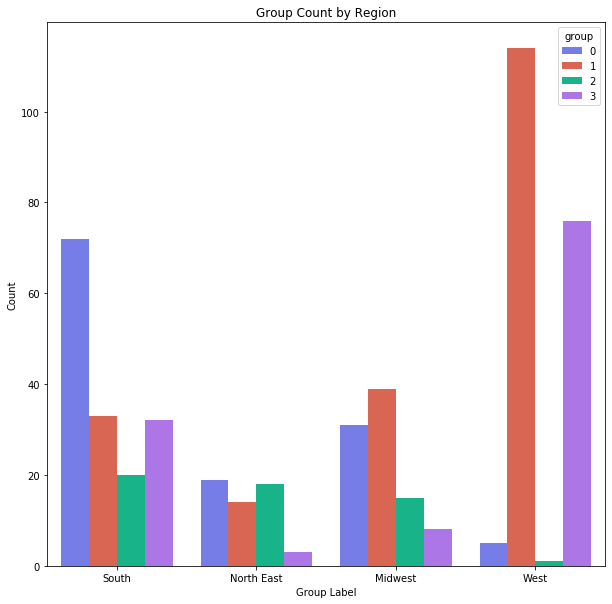

In [87]:
plt.figure(figsize = (10,10))
sns.countplot(x = 'Region', hue = 'group', data = cdc_og, palette = ['#636dfa', '#ef563b','#00cc96','#ac63fa'])
plt.title('Group Count by Region')
plt.xlabel('Group Label')
plt.ylabel('Count')
plt.show()